In [1]:
# --- my modules
from sample_selection import sample_selection
from proposed_algorithm import domain_invariant_unsupervised_sample_selection as diuss 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtply
import pandas as pd
import scipy as sp
import scipy.io as sp_io
from scipy.spatial.distance import cdist

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

## Pig Manure

In [3]:
txt_filename =  "./0Pig2004_New.TXT"
data = np.loadtxt(txt_filename)
data_initial = np.array(data) 

In [4]:
x_initial = data_initial[:,0:141]
y = data_initial[:,141:]
# choose DM: Dry matter (Second column in the y array) as the Y variable and divide into cal and test set
y_initial = y[:,1]

y_labels = ["pH",
"DM",
"OM",
"total_N",
"ammonium_N",
"P",
"K",
"Na",
"Ca",
"Mg"]

n = x_initial.shape
print(n)

n2 = y_initial.shape
print(n2)

(420, 141)
(420,)


In [ ]:
#Dataset for R
#data = pd.DataFrame(data_initial)
#data.to_excel('pig_data.xlsx', sheet_name='sheet1', index=False)

### <span style="color:#00BDFF">Setting calibration and test datasets</span>

In [5]:
n_cal = 256

rng = np.random.RandomState(7620987)
cal_samples = rng.choice(x_initial.shape[0], n_cal, replace = False)
nocal_samples = np.asarray([ii for ii in range(x_initial.shape[0]) if ii not in cal_samples])

x_all = np.array(x_initial)[cal_samples,0:]
y_all = np.array(y_initial)[cal_samples]

x_test = np.array(x_initial)[nocal_samples,0:]
y_test = np.array(y_initial)[nocal_samples]

y_all.shape = (y_all.shape[0],1)
y_test.shape = (y_test.shape[0],1)
print(x_all.shape)
print(y_all.shape)
print(x_test.shape)
print(y_test.shape)

(256, 141)
(256, 1)
(164, 141)
(164, 1)


In [ ]:
df = pd.DataFrame(y_all)
df.describe()

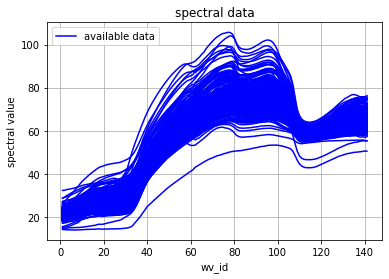

In [6]:
# visualize data
wv_range = np.arange(1,x_all.shape[1]+1) 
plt.plot(wv_range,x_all[0], c = "blue", label = "available data") #(Row 1)
plt.plot(wv_range,x_all.T, c = "blue") #.T is the transpose matrix (Column 1)
plt.xlabel("wv_id")
plt.ylabel("spectral value")
plt.title("spectral data")
plt.legend()
plt.grid()
plt.show()

In [7]:
# initial pca for exploratory analysis 
pca_mu = x_all.mean(axis=0)  # mean(axis=0) is an array with the mean per column

X_c = x_all - pca_mu #Mean centering X_initial
X_c_t = np.ascontiguousarray(X_c.transpose()) 
cov_X = X_c_t.dot(X_c)/(X_c.shape[0]-1) # ([X_c^T]*[[X_c]) / n ; 
svd_cov_X = np.linalg.svd(cov_X) # Singular Value Decomposition

chosen_pc = 20 #sugested number 

pc_loadings = svd_cov_X[0][:,0:chosen_pc] # first 25 coulums from left eigenvectors U
tscores = (x_all - pca_mu).dot(pc_loadings) #X centered * Loadings
x_all_predicted = tscores.dot(pc_loadings.T) + pca_mu

q_residuals = np.mean(np.power(x_all - x_all_predicted,2),axis=1) # Mean per row of (Xi -Xp)^2
hotelling_t2 = np.diag(tscores.dot(np.diag(1/svd_cov_X[1][0:chosen_pc])).dot(tscores.T)) 
#Dig( tscores(155,10)* Dia(1/SVD_Cov_X(650,1))*tscores^T)

print("proportion of variance first pc's: ",np.round(svd_cov_X[1]/np.sum(svd_cov_X[1]),6)[0:chosen_pc])
# Eigenvalue(i)/Sum(Eigenvalues)
# Eigenvalues = expalined variance

print(x_all)
x_all.shape

proportion of variance first pc's:  [8.11544e-01 1.27450e-01 3.87930e-02 1.26510e-02 5.26000e-03 1.57900e-03
 8.70000e-04 6.22000e-04 5.37000e-04 2.95000e-04 1.36000e-04 7.00000e-05
 4.10000e-05 2.90000e-05 2.50000e-05 1.70000e-05 1.10000e-05 8.00000e-06
 7.00000e-06 6.00000e-06]
[[18.7295227 19.1361065 19.3984814 ... 63.5293083 63.1823006 63.2852783]
 [15.0263405 15.0026588 14.9601812 ... 55.8071709 55.5931511 55.483326 ]
 [20.9163189 21.3927002 22.0592728 ... 63.9945869 63.9901314 63.4246025]
 ...
 [20.0424061 20.5167561 20.7937946 ... 60.5181999 60.7890434 61.3681068]
 [20.8135796 21.3016987 21.500433  ... 62.2033119 62.5713501 61.7042961]
 [18.624506  18.9705486 19.2303238 ... 61.8020363 61.4355049 61.9479713]]


(256, 141)

In [ ]:
pd.DataFrame(pc_loadings)

In [ ]:
pd.DataFrame(tscores)

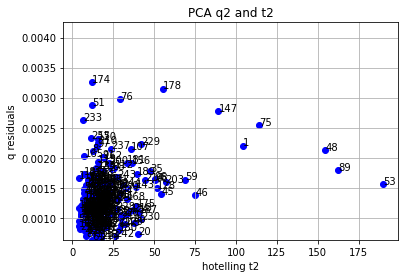

In [8]:
plt.scatter(hotelling_t2,q_residuals,c="blue")
for ii in range(hotelling_t2.shape[0]):
    plt.text(hotelling_t2[ii],q_residuals[ii], str(ii))
plt.grid()
plt.ylim(np.amin(q_residuals),np.amax(q_residuals)+0.001)
plt.xlabel("hotelling t2")
plt.ylabel("q residuals")
plt.title("PCA q2 and t2")
plt.show()
# No samples are going to be removed

In [ ]:
# --- observations to carry for unsupervised sample selection if necessary
#samples_initial_id = np.arange(0,len(x_all))
#drop_obs = [48,89,53] 
#keep_obs = [ii for ii in range(x_all.shape[0]) if ii not in drop_obs]

#x_all_keep = np.delete(x_all, obj = drop_obs, axis=0)
#samples_all_id = samples_initial_id[keep_obs]

#y_all_keep = np.delete(y_all, obj = drop_obs, axis=0)

#print(x_all_keep.shape)
#print(y_all_keep.shape)

In [ ]:
#Exporting calibration data to use in R
CAL_X= pd.DataFrame(x_all)
CAL_X.to_excel('0x_all_pig.xlsx', sheet_name='sheet1', index=False)
CAL_X

# <span style="color:#00BDFF">unsupervised sample selection</span>

In [9]:
# --- determine optimal complexity
d = 11 # number of lv
n_sel = 12*d+1
a = 20 # number of pc 
print("n: ", n_sel)
print("a: ", a)

n:  133
a:  20


In [10]:
my_sample_selection = sample_selection(x_all, ncp = a)  
my_sample_selection

## Z matrix for Diuss Method

In [10]:
sub_samples = diuss.sub_matrix(x_matrix = x_all, num_samples=n_sel)
Z=sub_samples[0]
X_minus_Z=sub_samples[1]
Z_samples=sub_samples[2]
X_minus_Z_samples=sub_samples[3]

Z= element [0] dimetion: (133, 141) numpy.ndarray
Y= element [1] dimetion: (123, 141) numpy.ndarray
Zsamples= element [2] length: 133 numpy.ndarray
Ysamples= element [3] length: 123 numpy.ndarray


## State of the art Methods

In [11]:
# The DOE selection method was performed in R using PCA and optFederov functions
DOE = [ 1, 2, 4, 8, 9, 10, 11, 12, 15, 19, 20, 21, 23, 25, 26, 27, 
28, 30, 33, 35, 40, 42, 45, 46, 47, 48, 52, 53, 55, 59, 61, 63, 
65, 66, 67, 68, 72, 73, 75, 76, 77, 78, 81, 82, 85, 88, 89, 90, 
91, 93, 96, 104, 107, 108, 109, 110, 112, 115, 118, 123, 124, 
125, 127, 128, 129, 131, 133, 134, 137, 138, 142, 143, 144, 145, 
146, 147, 155, 156, 158, 159, 160, 161, 162, 166, 168, 169, 170, 
171, 172, 174, 175, 176, 177, 178, 180, 181, 182, 184, 187, 189, 
192, 196, 197, 200, 203, 204, 206, 207, 210, 211, 212, 213, 214, 
215, 216, 221, 223, 224, 226, 227, 228, 229, 230, 236, 237, 239, 
240, 242, 243, 245, 247, 250, 253]

DOE = np.array(DOE)
DOE.shape

(133,)

In [12]:
Z_DOE= np.zeros(len(x_all),dtype=int)

for i in range(len(Z_DOE)):  
    if i in DOE:
        Z_DOE[i] = 1
Z_DOE

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])

In [13]:
# --- select samples
my_sample_selection = sample_selection(x_all, ncp = a)  
my_sample_selection.get_xcal_pca_scores()

selected_sets = {}

selected_sets["ks_sample"] = my_sample_selection.kennard_stone(Nout=n_sel, fixed_samples=None, use_pca_scores=True,distance_metric='mahalanobis')
selected_sets["duplex_sample"] = my_sample_selection.duplex(Nout = n_sel, use_pca_scores=True, distance_metric='mahalanobis')
selected_sets["puch_sample"] = my_sample_selection.puchwein(Nout = n_sel, factor_k=0.0001, use_pca_scores=True, distance_metric='mahalanobis')
selected_sets["clus_sample"] = my_sample_selection.clustering(Nout = n_sel , use_pca_scores=True, distance_metric='euclidean', linkage = "complete")
selected_sets["all_samples"] = np.full(len(x_all), 1, dtype=int)
selected_sets["DOE"] = Z_DOE

## Diuss Method

In [15]:
#Diuss using max sigmas from SVD
best_max=diuss.diuss_max(X = x_all, Z = Z, Y = X_minus_Z, Z_samples = Z_samples,
                         Y_samples = X_minus_Z_samples, iterations=4000)
#Diuss using sum of sigmas from SVD
best_sum=diuss.diuss_sum(X = x_all, Z = Z, Y = X_minus_Z, Z_samples = Z_samples,
                         Y_samples = X_minus_Z_samples, iterations=4000)

In [16]:
selected_sets["diuss_max"] = best_max[5]
selected_sets["diuss_sum"] = best_sum[5]

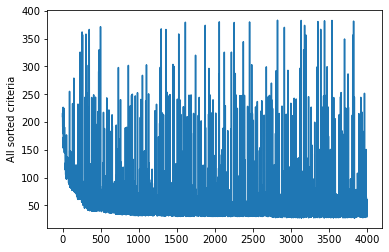

In [18]:
#The criterion shows convergence diuss_max
diuss.crit_behavior(all_crit = best_max[4])

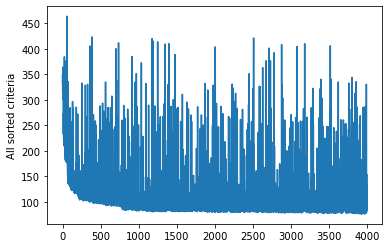

In [19]:
#The criterion shows convergence diuss_sum
diuss.crit_behavior(all_crit = best_sum[4])

In [17]:
print("KS: ",selected_sets["ks_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["ks_sample"]))
print("Duplex: ",selected_sets["duplex_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["duplex_sample"]))
print("puch_sample: ",selected_sets["puch_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["puch_sample"]))
print("clus_sample: ", selected_sets["clus_sample"],"total_samples:",diuss.count_of_ones(array = selected_sets["clus_sample"]))
print("diuss_max:",selected_sets["diuss_max"],"total_samples:",diuss.count_of_ones(array = selected_sets["diuss_max"]))
print("diuss_sum:",selected_sets["diuss_sum"],"total_samples:",diuss.count_of_ones(array = selected_sets["diuss_sum"]))
print("DOE:",selected_sets["DOE"],"total_samples:",diuss.count_of_ones(array = selected_sets["DOE"]))
print("all_samples:",selected_sets["all_samples"],"total_samples:",diuss.count_of_ones(array = selected_sets["all_samples"]))

KS:  [0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 0
 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 0 1 0
 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1
 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1
 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 1
 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1
 0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0] total_samples: 133
Duplex:  [1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0
 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0
 1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0
 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1
 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1
 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1

In [18]:
def sample_list(method_samples):
    l = len(method_samples)
    r=np.zeros((), dtype=int)

    for i in range(l):
        if method_samples[i] == 1:
            r=np.append(r,i)
    r=r[1:] # To eleiminate the first 0 from np.Zeros
    return(r)

In [19]:
Ks = sample_list(method_samples=selected_sets["ks_sample"])
dup = sample_list(method_samples=selected_sets["duplex_sample"])
puch = sample_list(method_samples=selected_sets["puch_sample"])
clus = sample_list(method_samples=selected_sets["clus_sample"])
d_max = sample_list(method_samples=selected_sets["diuss_max"])
d_sum = sample_list(method_samples=selected_sets["diuss_sum"])


In [50]:
d_sum

array([  1,   3,   4,   5,   6,   7,   8,  10,  12,  13,  14,  16,  18,
        19,  22,  23,  25,  27,  29,  38,  41,  42,  43,  46,  50,  51,
        52,  53,  54,  56,  58,  59,  60,  64,  65,  66,  67,  68,  70,
        71,  73,  75,  76,  89,  90,  97,  98,  99, 100, 105, 107, 108,
       113, 114, 115, 116, 118, 119, 120, 121, 124, 126, 127, 129, 131,
       132, 136, 137, 138, 140, 141, 142, 145, 148, 149, 154, 155, 157,
       158, 161, 164, 166, 171, 173, 175, 178, 179, 180, 183, 184, 186,
       187, 188, 190, 193, 194, 199, 201, 202, 206, 208, 209, 210, 212,
       213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 225, 226, 229,
       230, 233, 234, 236, 237, 238, 239, 240, 241, 242, 245, 246, 248,
       249, 251, 253])

In [20]:
# Samples ID from 0 to 255 for a total n=256
print("ks")
print(Ks)
print("dup")
print(dup)
print("puch")
print(puch)
print("clus")
print(clus)
print("d_max")
print(d_max)
print("d_sum")
print(d_sum)
print("DOE")
print(DOE)

ks
[  1   4   9  10  11  14  15  18  19  20  21  25  26  27  28  29  30  32
  35  40  41  45  46  47  48  51  53  54  56  59  62  63  66  67  68  69
  72  75  76  77  79  81  82  88  89  90  93  96  97 102 104 107 110 111
 112 113 115 118 123 124 125 126 127 128 129 131 133 137 138 142 143 144
 145 146 147 148 154 155 156 160 162 164 166 168 169 171 172 175 178 180
 181 182 184 187 189 190 191 193 196 198 200 203 204 206 207 208 211 212
 213 214 215 216 221 223 224 226 227 228 229 230 232 236 237 238 239 242
 243 245 247 250 252 253 254]
dup
[  0   1   2   3   8  10  12  13  14  15  16  18  19  22  23  24  29  30
  33  35  39  40  41  43  47  49  51  52  53  54  56  59  60  61  62  63
  65  66  67  68  71  72  74  78  80  81  83  84  85  87  90  92  93  97
  99 105 106 108 109 112 113 115 116 118 122 123 124 127 128 129 130 134
 135 136 137 138 140 141 143 144 145 147 148 149 150 151 152 154 156 157
 158 159 162 163 164 165 168 169 170 172 173 175 177 180 183 184 187 190
 191 193 195 1

In [22]:
# --- select one sample set for cal and eigenevaluation
svd_methods = {} # dictionary
# [] is a list

for method_name in selected_sets.keys():    

    selected_cal_set = selected_sets[method_name].copy()

    # --- evaluate selected cal set: S matrix eigen decomp

    x_selected = x_all[selected_cal_set==1,:]
    Xs_c = x_selected - x_selected.mean(axis=0)
    Xs_c_t = np.ascontiguousarray(Xs_c.transpose())
    cov_Xs = Xs_c_t.dot(Xs_c)/Xs_c.shape[0]
    svd_selected = np.linalg.svd(cov_Xs)
    
    svd_methods[method_name] = svd_selected
    
print("done")

done


determinant eigenvectors: 

ks_sample :  0.943
duplex_sample :  0.672
puch_sample :  0.933
clus_sample :  0.892
all_samples :  1.0
DOE :  0.946
diuss_max :  0.656
diuss_sum :  0.791


<ipython-input-23-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-23-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-23-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-23-695fb3db0d93>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)
<ipython-input-23-695fb3db0d93>:34: 

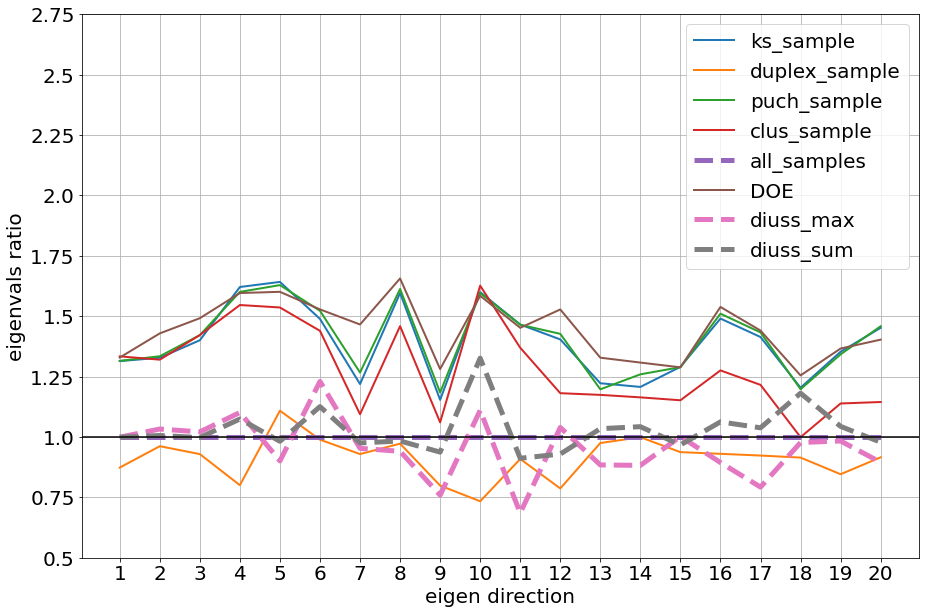

In [23]:
# --- visualize comparison svd
X_c = x_all - x_all.mean(axis=0)
X_c_t = np.ascontiguousarray(X_c.transpose())
cov_X = X_c_t.dot(X_c)/X_c.shape[0]
svd_cov_X = np.linalg.svd(cov_X)

# eigenvect comparison

print("determinant eigenvectors: \n")

for method_name in svd_methods.keys():
    
    svd_selected = svd_methods[method_name]
    eigen_vals_ratio = svd_selected[1][0:a]/svd_cov_X[1][0:a]
    eigen_vect_comparison = svd_selected[0][:,0:a].T.dot(svd_cov_X[0][:,0:a])
    eigen_vect_criterion = np.abs(np.linalg.det(eigen_vect_comparison))
    print(method_name,": ",np.round(eigen_vect_criterion,3))
    
    
# eigenval comparison

font_size = 20
yticks = np.arange(0.5,3, 0.25)
xticks = np.arange(1,a+1)


fig, ax = plt.subplots(figsize = (15,10))

for method_name in svd_methods.keys():
    
    svd_selected = svd_methods[method_name]
    eigen_vals_ratio = svd_selected[1][0:a]/svd_cov_X[1][0:a]
    if method_name =="diuss_max" or method_name =="diuss_sum" or method_name =="all_samples" :
        ax.plot(xticks,eigen_vals_ratio, Linewidth =5 , label = method_name, linestyle='dashed')
    else:
        ax.plot(xticks,eigen_vals_ratio, Linewidth = 2, label = method_name)

        
    
ax.grid()
ax.axhline(y=1, c = "black")
ax.set_xlabel("eigen direction", fontsize = font_size)
ax.set_xticks(xticks)
ax.set_xticklabels(labels = xticks, fontsize = font_size)
ax.set_ylabel("eigenvals ratio", fontsize = font_size)
ax.set_yticks(yticks)
ax.set_yticklabels(labels = yticks, fontsize = font_size)
ax.legend(fontsize = font_size)
plt.show()

## Cross validation PLSR model 

In [24]:
total_lv = 20
n_splits_cv = 10
n_shuffles = 1

In [25]:
model_evaluation = {}

for method_name in selected_sets.keys():
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= y_all[selected_cal_set==1,:]
    
    parameters = {'n_components': list(range(1,total_lv+1))}
    pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}
    
    for nn in range(n_shuffles):

        pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
        my_pls = PLSRegression(scale=False)
        my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
        my_pls_cv.fit( xcal_pls,  ycal_pls)
        
    model_evaluation[method_name] = {"rmsecv":-1*my_pls_cv.cv_results_["mean_test_rmse"],
                                    "r2cv":my_pls_cv.cv_results_["mean_test_r2"],
                                    }    
    # Note check this -1

<ipython-input-26-0c0da9c2d2e0>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-26-0c0da9c2d2e0>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-26-0c0da9c2d2e0>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
<ipython-input-26-0c0da9c2d2e0>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange

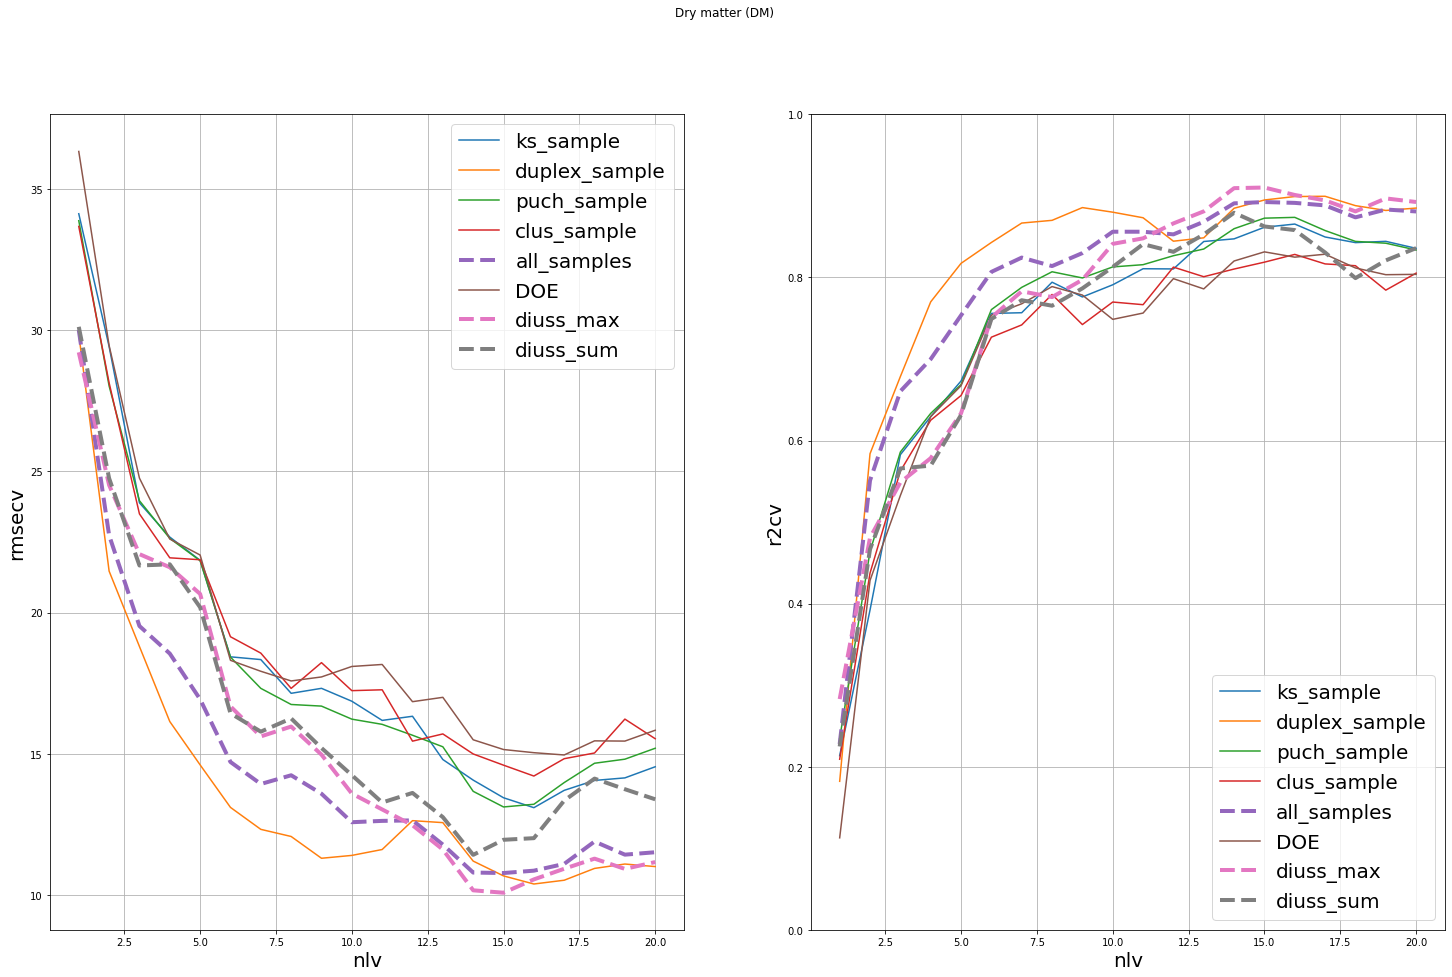

In [26]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25,15))

for method_name in model_evaluation.keys():

    rmsecv = model_evaluation[method_name]["rmsecv"]
    r2cv = model_evaluation[method_name]["r2cv"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name, Linewidth =4,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name, Linewidth =4,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsecv, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2cv, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsecv", fontsize = font_size)
ax[1].set_ylabel("r2cv", fontsize = font_size)

ax[1].set_ylim([0,1])  

ax[0].grid()
ax[1].grid()

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Dry matter (DM)"
fig.suptitle(y_name)

plt.show()

## PLSR

In [27]:
model_evaluation2 = {}

for method_name in selected_sets.keys():
    rmsep_all = np.zeros(total_lv)
    r2p_all = np.zeros(total_lv)
    
    selected_cal_set = selected_sets[method_name]
    xcal_pls = x_all[selected_cal_set==1,:]
    ycal_pls= y_all[selected_cal_set==1,:]
    xtest_pls = x_test
    ytest_pls= y_test
        
    for ii, chosen_lv in enumerate(range(1,total_lv+1)):
        
        my_pls = PLSRegression(n_components = chosen_lv,scale=False)
        my_pls.fit(xcal_pls, ycal_pls)
        x_mean = xcal_pls.mean(axis=0)
        y_mean = ycal_pls.mean(axis=0)
        
        # deliver model
        B = my_pls.coef_
        beta = y_mean - (x_mean.dot(B))

        ytest_pls_pred = xtest_pls.dot(B) + beta
        rmsep_all[ii] = np.sqrt(mean_squared_error(ytest_pls, ytest_pls_pred))
        r2p_all[ii] = r2_score(ytest_pls, ytest_pls_pred)
        
    model_evaluation2[method_name] = {"rmsep":rmsep_all,
                                    "r2p":r2p_all,
                                    }    

<ipython-input-34-53268630cf18>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-34-53268630cf18>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-34-53268630cf18>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
<ipython-input-34-53268630cf18>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax[1].plot(np.arange(1,

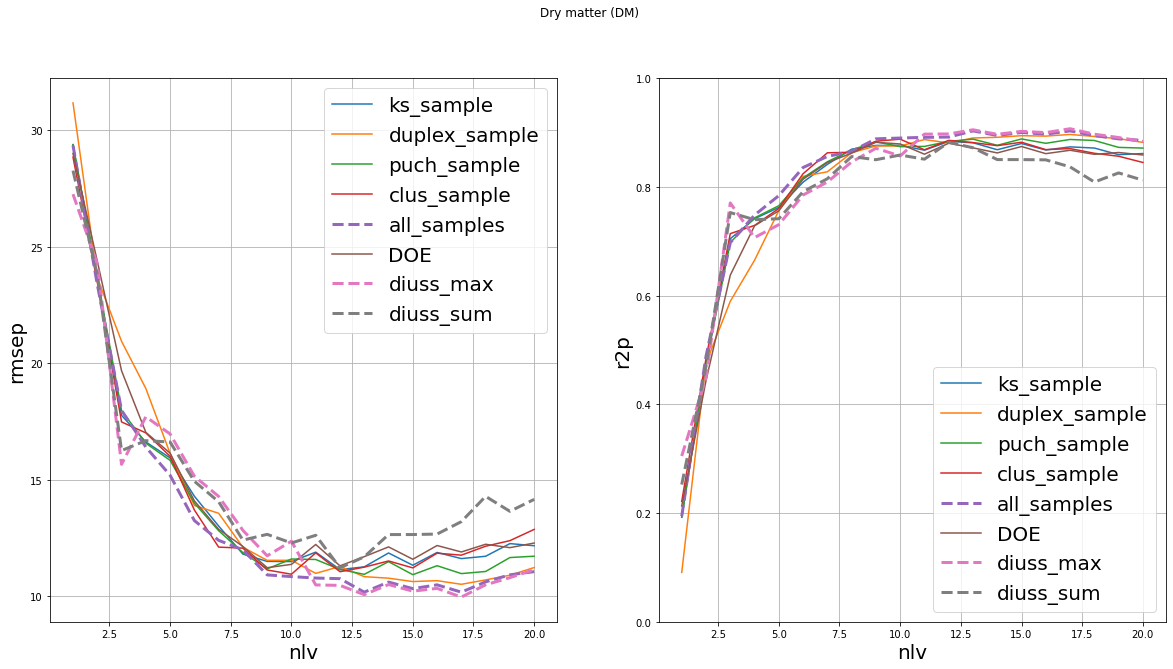

In [34]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))

for method_name in model_evaluation2.keys():

    rmsep = model_evaluation2[method_name]["rmsep"]
    r2p = model_evaluation2[method_name]["r2p"]

    if method_name =='diuss_max' or method_name =='diuss_sum' or method_name =='all_samples'  :
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name, Linewidth =3,linestyle='dashed')
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name, Linewidth =3,linestyle='dashed')        
    else:
        ax[0].plot(np.arange(1, total_lv+1),rmsep, label = method_name)
        ax[1].plot(np.arange(1, total_lv+1),r2p, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("rmsep", fontsize = font_size)
ax[1].set_ylabel("r2p", fontsize = font_size)

ax[0].grid()
ax[1].grid()

ax[1].set_ylim([0,1])  

ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

y_name = "Dry matter (DM)"
fig.suptitle(y_name)

plt.show()



In [57]:
model_evaluation2['ks_sample']['rmsep']

array([29.37853095, 23.67010453, 17.76475211, 16.62025642, 15.93831196,
       14.29423765, 13.0156194 , 11.81129058, 11.49659091, 11.49041997,
       11.89407515, 11.14689621, 11.26281065, 11.85802111, 11.33158688,
       11.8803924 , 11.61723592, 11.71758076, 12.25979926, 12.16969233])

In [51]:
Sd_y_test = np.std(y_test, axis=0)


array([32.68879709])

In [61]:
RPD_ks = Sd_y_test/model_evaluation2['ks_sample']['rmsep']
RPD_dup = Sd_y_test/model_evaluation2['duplex_sample']['rmsep']
RPD_puch = Sd_y_test/model_evaluation2['puch_sample']['rmsep']
RPD_clus = Sd_y_test/model_evaluation2['clus_sample']['rmsep']
RPD_DOE = Sd_y_test/model_evaluation2['DOE']['rmsep']
RPD_d_max = Sd_y_test/model_evaluation2['diuss_max']['rmsep']
RPD_d_sum = Sd_y_test/model_evaluation2['diuss_sum']['rmsep']
RPD_all = Sd_y_test/model_evaluation2['all_samples']['rmsep']


In [65]:
RPD = {}
RPD["RPD_ks"] =RPD_ks
RPD["RPD_dup"] =RPD_dup
RPD["RPD_ks"] =RPD_ks
RPD["RPD_clus"] =RPD_clus
RPD["RPD_DOE"] =RPD_DOE
RPD["RPD_d_max"] =RPD_ks
RPD["RPD_d_sum"] =RPD_puch
RPD["RPD_all"] =RPD_all

In [66]:
RPD

{'RPD_ks': array([1.11267637, 1.38101617, 1.84009306, 1.96680462, 2.05095729,
        2.28685138, 2.5115053 , 2.76758893, 2.84334698, 2.84487401,
        2.74832609, 2.932547  , 2.90236586, 2.75668232, 2.88475016,
        2.75149136, 2.81381882, 2.78972236, 2.66634032, 2.68608246]),
 'RPD_dup': array([1.04878488, 1.38124236, 1.56089927, 1.72792624, 2.02658431,
        2.35234496, 2.41036222, 2.70100176, 2.83216151, 2.8314402 ,
        2.97615556, 2.89782839, 3.01508451, 3.03324621, 3.07464646,
        3.06349245, 3.1089477 , 3.05407393, 2.99777781, 2.91003583]),
 'RPD_clus': array([1.13341749, 1.39238896, 1.87012416, 1.92153759, 2.04247327,
        2.38547846, 2.69934055, 2.70940202, 2.93761667, 2.98608468,
        2.75561506, 2.95707923, 2.90567458, 2.83854132, 2.9137145 ,
        2.75877529, 2.77854575, 2.6908577 , 2.63897823, 2.53998305]),
 'RPD_DOE': array([1.12728304, 1.34064912, 1.66134834, 1.91902341, 2.02513192,
        2.31946747, 2.53885449, 2.69279891, 2.91179191, 2.87512369

[1.11267637 1.38101617 1.84009306 1.96680462 2.05095729 2.28685138
 2.5115053  2.76758893 2.84334698 2.84487401 2.74832609 2.932547
 2.90236586 2.75668232 2.88475016 2.75149136 2.81381882 2.78972236
 2.66634032 2.68608246]
[1.04878488 1.38124236 1.56089927 1.72792624 2.02658431 2.35234496
 2.41036222 2.70100176 2.83216151 2.8314402  2.97615556 2.89782839
 3.01508451 3.03324621 3.07464646 3.06349245 3.1089477  3.05407393
 2.99777781 2.91003583]
[1.13341749 1.39238896 1.87012416 1.92153759 2.04247327 2.38547846
 2.69934055 2.70940202 2.93761667 2.98608468 2.75561506 2.95707923
 2.90567458 2.83854132 2.9137145  2.75877529 2.77854575 2.6908577
 2.63897823 2.53998305]
[1.12728304 1.34064912 1.66134834 1.91902341 2.02513192 2.31946747
 2.53885449 2.69279891 2.91179191 2.87512369 2.67433915 2.89125882
 2.79373713 2.69730312 2.82072804 2.6842368  2.74659371 2.67234098
 2.70454382 2.66091155]
[1.11267637 1.38101617 1.84009306 1.96680462 2.05095729 2.28685138
 2.5115053  2.76758893 2.84334698 2.

TypeError: 'AxesSubplot' object is not subscriptable

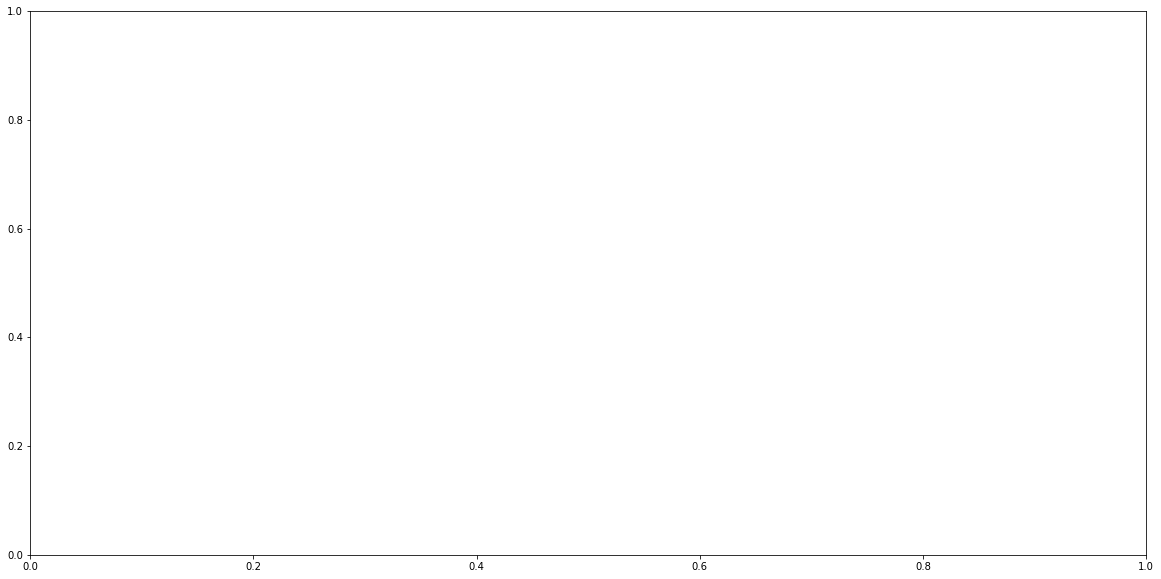

In [74]:
# Results Plots
fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,10))

for method_name in RPD.keys():

    RPD_plot = RPD[method_name]
    print(RPD_plot)
    if method_name =="RPD_d_max" or method_name =="RPD_d_sum" or method_name =="RPD_all"  :
        ax[0].plot(np.arange(1, 20),RPD_plot, label = method_name, Linewidth =3,linestyle='dashed')       
    #else:
    #    ax[0].plot(np.arange(1, 20),RPD_plot, label = method_name)

ax[0].set_xlabel("nlv", fontsize = font_size)
#ax[1].set_xlabel("nlv", fontsize = font_size)

ax[0].set_ylabel("RPD", fontsize = font_size)
#ax[1].set_ylabel("r2p", fontsize = font_size)

ax[0].grid()
#ax[1].grid()

#ax[1].set_ylim([0,1])  

ax[0].legend(fontsize = font_size)
#ax[1].legend(fontsize = font_size)

y_name = "Dry matter (DM)"
fig.suptitle(y_name)

plt.show()

